In [6]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import shap

In [7]:
#Loading and preprocessing data
data = pd.read_csv('/kaggle/input/homestays/Homestays_Data(in).csv')

In [8]:
data.columns

Index(['id', 'log_price', 'property_type', 'room_type', 'amenities',
       'accommodates', 'bathrooms', 'bed_type', 'cancellation_policy',
       'cleaning_fee', 'city', 'description', 'first_review',
       'host_has_profile_pic', 'host_identity_verified', 'host_response_rate',
       'host_since', 'instant_bookable', 'last_review', 'latitude',
       'longitude', 'name', 'neighbourhood', 'number_of_reviews',
       'review_scores_rating', 'thumbnail_url', 'zipcode', 'bedrooms', 'beds'],
      dtype='object')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      74111 non-null  int64  
 1   log_price               74111 non-null  float64
 2   property_type           74111 non-null  object 
 3   room_type               74111 non-null  object 
 4   amenities               74111 non-null  object 
 5   accommodates            74111 non-null  int64  
 6   bathrooms               73911 non-null  float64
 7   bed_type                74111 non-null  object 
 8   cancellation_policy     74111 non-null  object 
 9   cleaning_fee            74111 non-null  bool   
 10  city                    74111 non-null  object 
 11  description             74111 non-null  object 
 12  first_review            58247 non-null  object 
 13  host_has_profile_pic    73923 non-null  object 
 14  host_identity_verified  73923 non-null

 # **1. FEATURE ENGINEERING**

In [10]:
#Creating host_tenure feature, providing a measure of host experience. 
data['host_since'] = pd.to_datetime(data['host_since'])
data['Host_Tenure'] = (datetime.now() - data['host_since']).dt.days / 365.00

In [11]:
#Amenities_count, quantify the property offerings
data['Amenities_count'] = data['amenities'].apply(lambda x: len(x.split(',')))

In [12]:
#Adding Days_Since_Last_Review in order to assess listing activity and relevance
data['last_review'] = pd.to_datetime(data['last_review'])
data['Days_Since_Last_Review'] = (datetime.now() - data['last_review']).dt.days

In [13]:
data.to_csv('Modified_data.csv',index=False)

# **2. Exploratory Data Analysis (EDA)**

In [14]:
# Conversion
data = pd.read_csv('Modified_data.csv')
data = pd.get_dummies(data, columns=['room_type', 'property_type'], drop_first=True)

numerical_cols = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'Host_Tenure', 'number_of_reviews', 'log_price']
data[numerical_cols] = data[numerical_cols].apply(pd.to_numeric, errors='coerce')

data.dropna(subset=numerical_cols, inplace=True)


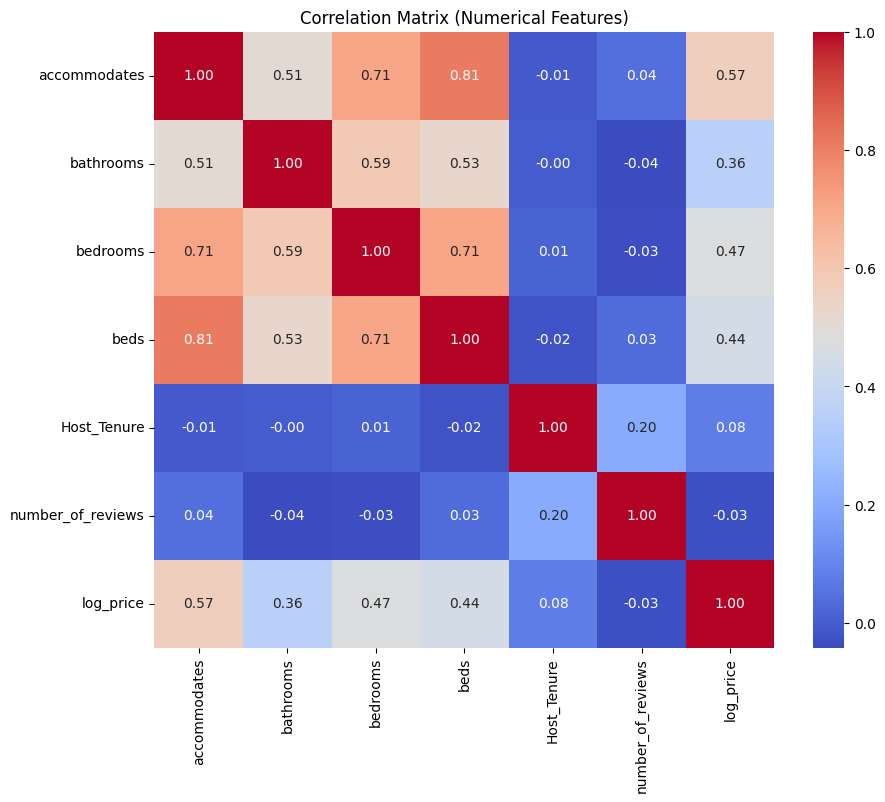

In [15]:
# Correlation Matrix for the modified dataset
correlation_matrix = data[numerical_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix (Numerical Features)')
plt.show()


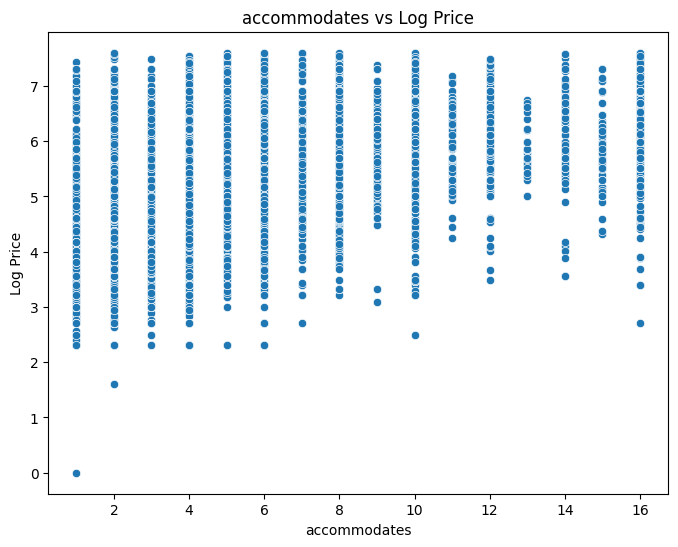

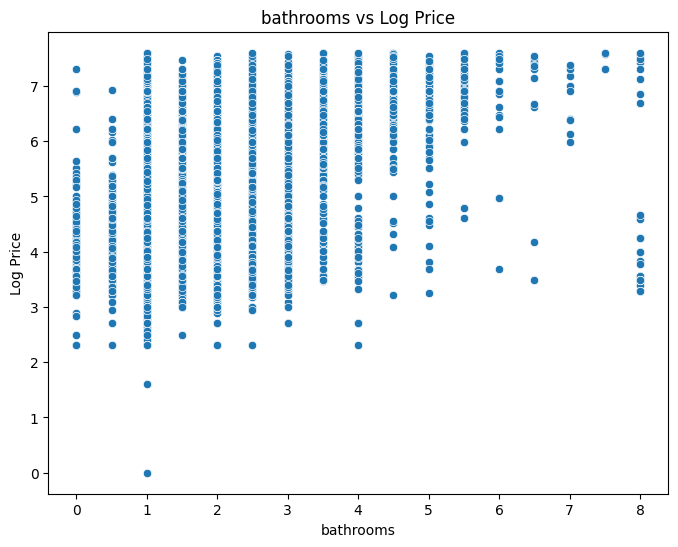

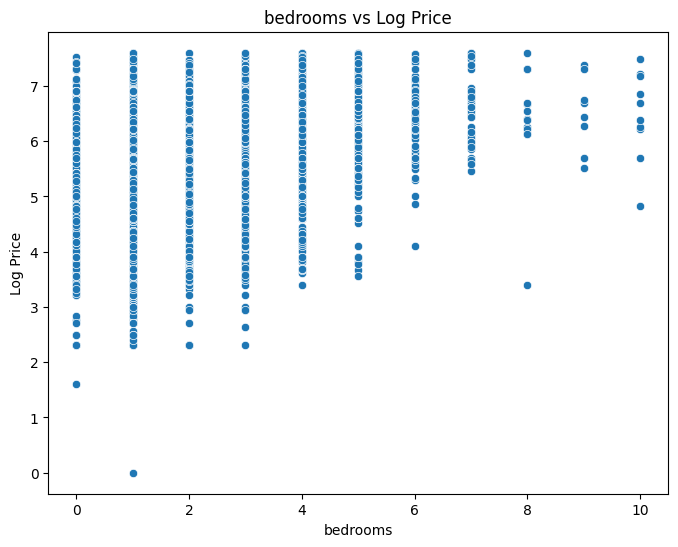

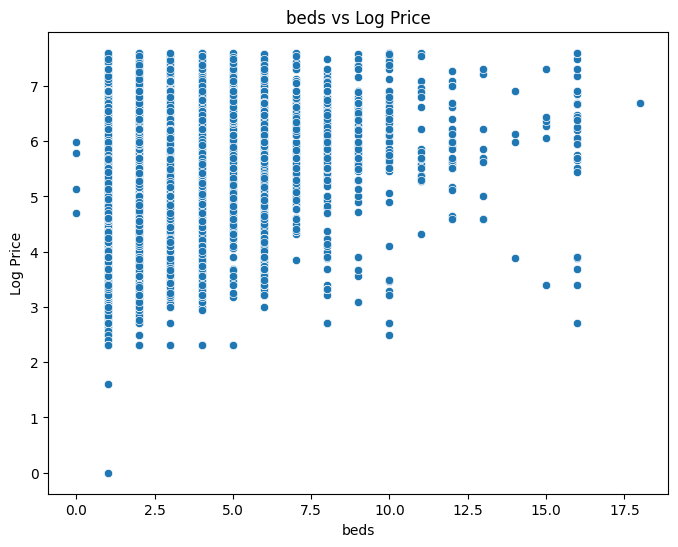

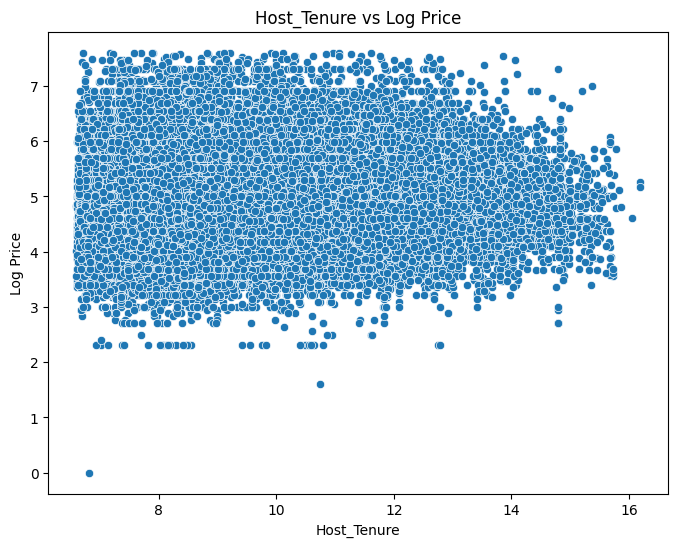

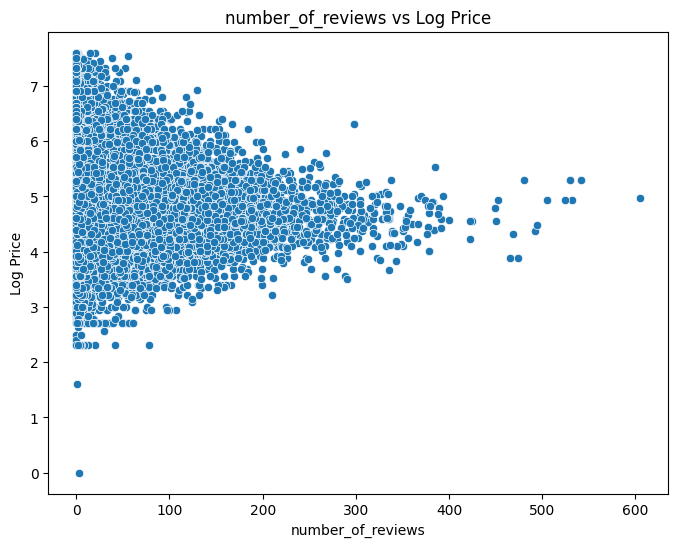

In [16]:
# Scatter plots to explore relationships between variables.

for feature in numerical_cols[:-1]: 
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=data, x=feature, y='log_price')
    plt.title(f'{feature} vs Log Price')
    plt.xlabel(feature)
    plt.ylabel('Log Price')
    plt.show()


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


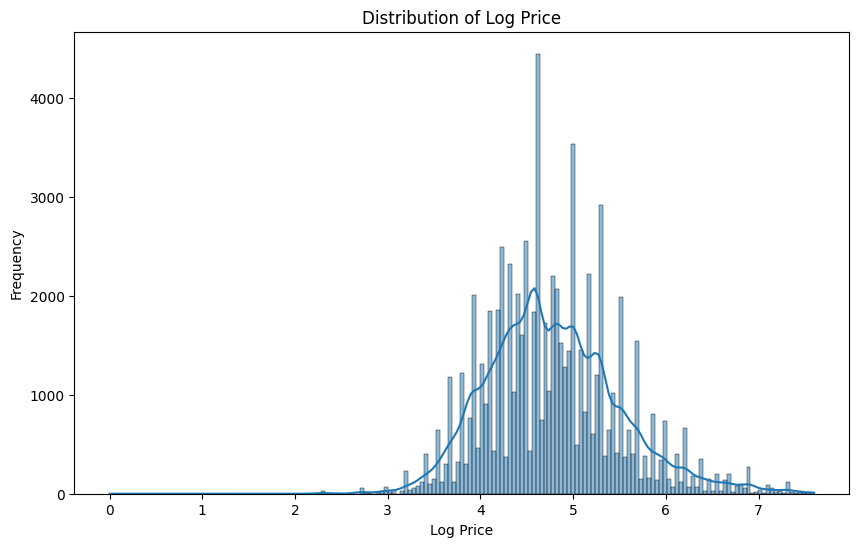

In [17]:
# Histogram for distribution analysis
plt.figure(figsize=(10, 6))
sns.histplot(data['log_price'], kde=True)
plt.title('Distribution of Log Price')
plt.xlabel('Log Price')
plt.ylabel('Frequency')
plt.show()

# **3. Geospatial Analysis**

In [18]:
import folium
from folium.plugins import HeatMap

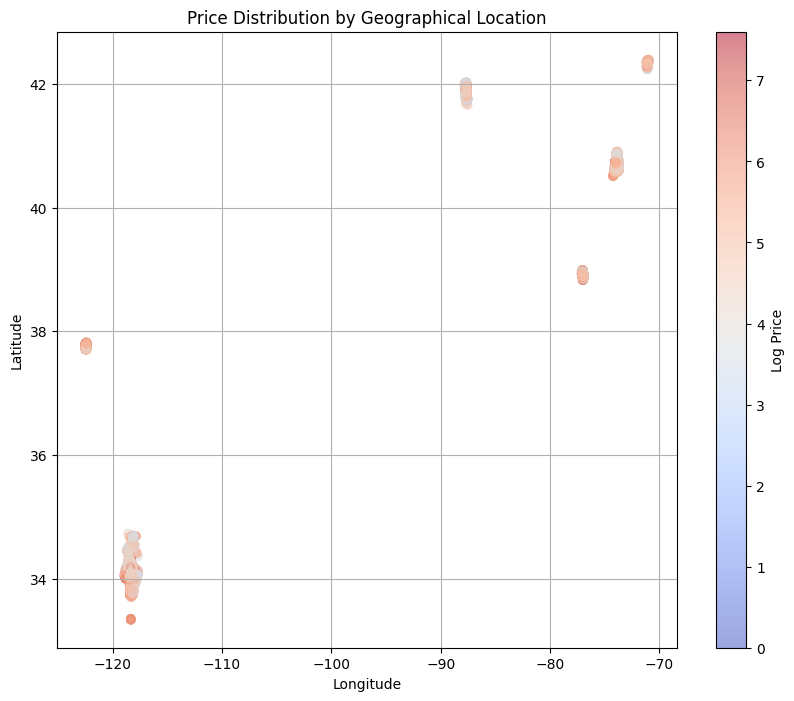

In [19]:
mean_lat = data['latitude'].mean()
mean_lon = data['longitude'].mean()
homestay_map = folium.Map(location=[mean_lat, mean_lon], zoom_start=12)

# Adding markers for each listing
for index, row in data.iterrows():
    folium.Marker([row['latitude'], row['longitude']], popup=row['name']).add_to(homestay_map)

# Save the map as an HTML file
homestay_map.save("homestay_listings_map.html")

# Visually assessing price distribution
plt.figure(figsize=(10, 8))
plt.scatter(data['longitude'], data['latitude'], c=data['log_price'], cmap='coolwarm', alpha=0.5)
plt.colorbar(label='Log Price')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Price Distribution by Geographical Location')
plt.grid(True)
plt.show()

# **4. Sentiment Analysis on Textual Data**